In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 130

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow.keras.backend as kb
import tensorflow.keras.losses

from tensorflow.python.ops import math_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import ops

from IPython.display import clear_output

import Settings
import NeuralNetwork

In [2]:
def lorentzian(x, w=.5, c=0):
    return w**2 / (w**2 + (2*x - 2*c)**2)

def generateBatchSparse(batchsize, widthBounds=[.2, .8], centerBounds=[-.5, .5], xBounds=[-1, 1], xLength=30):
    lorentzians = np.zeros([batchsize, 1, xLength])
    
    widths = np.random.uniform(widthBounds[0], widthBounds[1], size=batchsize)
    centers = np.random.uniform(centerBounds[0], centerBounds[1], size=batchsize)
    
    xArr = np.linspace(xBounds[0], xBounds[1], xLength)
    
    lorentzians[:,0,:] = np.array([lorentzian(xArr, w=widths[i], c=centers[i]) for i in range(batchsize)])
    
    # Now find the maxima
    #maxima = np.zeros([batchsize, xLength, 1]) 
    #maxima[:,:,0] = np.array([[np.argmax(lorentzians[i,:,0]) == j for j in range(xLength)] for i in range(batchsize)])
    maxima = np.array([np.argmax(lorentzians[i,0,:]) for i in range(batchsize)])
    return lorentzians, maxima

def generateBatchOneHot(batchsize, widthBounds=[.2, .8], centerBounds=[-.5, .5], xBounds=[-1, 1], xLength=30):
    lorentzians = np.zeros([batchsize, 1, xLength])
    
    widths = np.random.uniform(widthBounds[0], widthBounds[1], size=batchsize)
    centers = np.random.uniform(centerBounds[0], centerBounds[1], size=batchsize)
    
    xArr = np.linspace(xBounds[0], xBounds[1], xLength)
    
    lorentzians[:,0,:] = np.array([lorentzian(xArr, w=widths[i], c=centers[i]) for i in range(batchsize)])
    
    # Now find the maxima
    maxima = np.zeros([batchsize, 1, xLength]) 
    maxima[:,0,:] = np.array([[np.argmax(lorentzians[i,0,:]) == j for j in range(xLength)] for i in range(batchsize)])
    #maxima = np.array([np.argmax(lorentzians[i,0,:]) for i in range(batchsize)])
    return lorentzians, maxima

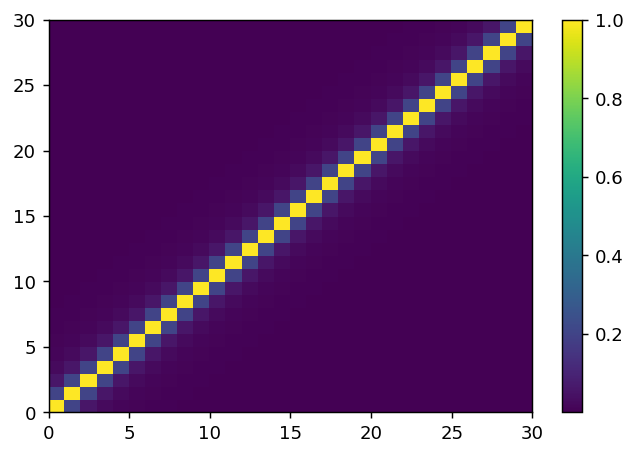

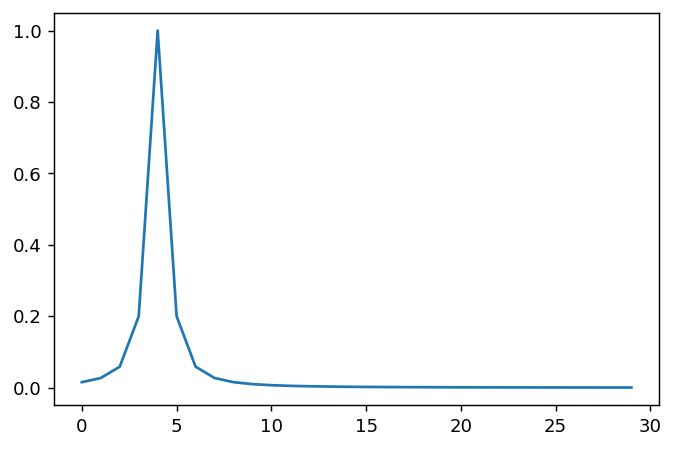

In [88]:
def linearWeight(sampleLength):
    wVec = np.zeros([sampleLength, sampleLength])
    for i in range(sampleLength):
        wVec[i] = np.abs([k - i for k in range(sampleLength)])
        wVec[i] = np.max(wVec[i]) - wVec[i]
        wVec[i] /= np.sum(wVec[i])

    return wVec

def deltaWeight(sampleLength):
    wVec = np.zeros([sampleLength, sampleLength])
    for i in range(sampleLength):
        wVec[i,i] = 1
        
    return wVec

def lorentzianWeight(sampleLength, width=1):
    wVec = np.zeros([sampleLength, sampleLength], dtype=np.float32)
    iArr = np.arange(sampleLength)
    for i in range(sampleLength):
        wVec[i] = lorentzian(iArr, w=width, c=i)
        
    return wVec

def pCCE(target, output, weightVector, axis=-1):
    
    # scale preds so that the class probas of each sample sum to 1
    output = output / math_ops.reduce_sum(output, -1, True)

    # Take projections into the weight vectors
    outputProjection = tf.tensordot(output, weightVector, axes=1)
    targetProjection = tf.tensordot(target, weightVector, axes=1)

    # Make sure there are no invalid values in the logarithm
    epsilon_ = constant_op.constant(kb.epsilon(), output.dtype.base_dtype)
    outputProjection = clip_ops.clip_by_value(outputProjection, epsilon_, 1. - epsilon_)

    return -math_ops.reduce_sum(targetProjection * math_ops.log(outputProjection), -1)

N = 30
#fig = plt.subplot(projection='3d')

#iArr = np.arange(N)
w = lorentzianWeight(N)

#for i in range(N):
#    fig.plot(xs=iArr, ys=np.repeat(iArr[i], N), zs=w[i])
#plt.show()

#print(np.sum(w[0]))

plt.pcolor(w)
plt.colorbar()
plt.show()

plt.plot(w[4])
plt.show()

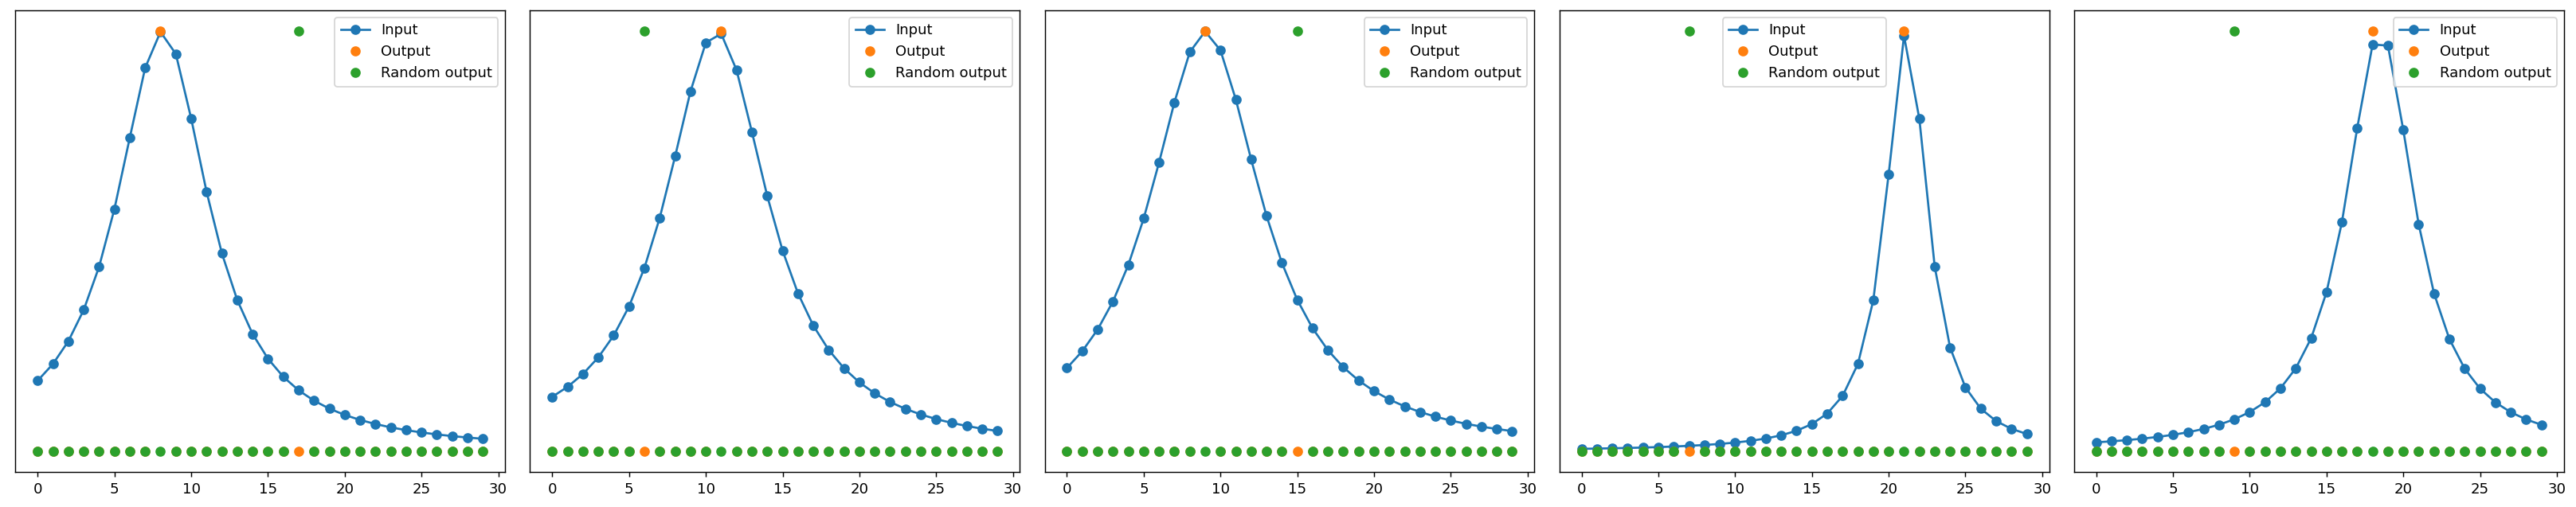

InvalidArgumentError: cannot compute MatMul as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:MatMul]

In [89]:
inputs, outputs = generateBatchOneHot(5)

fakePrediction = np.zeros_like(outputs)
for i in range(len(fakePrediction)):
    fakePrediction[i,0,np.random.randint(0, N)] = 1

fig, ax = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):
    ax[i].plot(inputs[i,0,:], 'o-', label='Input')
    ax[i].plot(outputs[i,0,:], 'o', label='Output')
    ax[i].plot(fakePrediction[i,0,:], 'o', label='Random output')
    ax[i].set_yticks([])
    ax[i].legend()
    #ax[i].set_xticks([])
    
fig.tight_layout()
plt.show()

weightVector = lorentzianWeight(N)

final = pCCE(outputs, fakePrediction, lorentzianWeight(30))

print(final)

In [90]:
def keras_CCE(target, output, axis=-1):
    #target = ops.convert_to_tensor(target)
    #output = ops.convert_to_tensor(output)
    #target.shape.assert_is_compatible_with(output.shape)

    # scale preds so that the class probas of each sample sum to 1
    output = output / math_ops.reduce_sum(output, axis, True)
    # Compute cross entropy from probabilities.
    epsilon_ = constant_op.constant(kb.epsilon(), output.dtype.base_dtype)
    output = clip_ops.clip_by_value(output, epsilon_, 1. - epsilon_)
    return -math_ops.reduce_sum(target * math_ops.log(output), axis)

def mse(y_actual, y_predicted):
    mseComponent = kb.mean(kb.sum(kb.square(y_actual - y_predicted)))
    return mseComponent
    
def fake_loss(y_actual, y_predicted):
    return np.ones([len(y_actual), 1])
    
def localizationError(y_actual, y_predicted):
    # Two contributions to total error:
    # Normalization error
    #normalizationError = kb.sum(y_predicted) - kb.ones_like(y_actual)

    print(y_predicted)
    print(y_actual)
    argMax = kb.zeros([kb.shape(y_actual)[0], 1])
    argMax[:][0] = [y_actual[i] - kb.argmax(y_predicted[i]) for i in range(kb.shape(y_actual)[0])]
    print(argMax)
    #localizationComponent = kb.cast(kb.mean(kb.sum(kb.abs(kb.argmax(y_predicted, axis=1) - kb.argmax(y_actual, axis=1)), axis=-1), axis=-1), dtype='float64')
    #print(np.shape(localizationComponent))
    return argMax #normalizationError + localizationError

# This sets up our net that will be used to train on various scores
def initializeNet(sample_length=30):
    model = keras.Sequential()

    # Add the input layer. None shape so that we can pass a variable length
    # array in
    model.add(layers.Input(shape=(1,sample_length)))

    # Add two LSTM layers. No particular reason for 2, just seeing how it works
    # The return_sequences lets you chain together LSTM layers, otherwise it will
    # mess with the shape
    model.add(layers.LSTM(sample_length, return_sequences=True, activation='relu'))
    #model.add(layers.LSTM(sample_length, return_sequences=True, activation='sigmoid'))
    #model.add(layers.LSTM(1, return_sequences=True, activation='softmax'))

    model.add(layers.Dense(sample_length, activation='softmax'))
    
    def partial_pCCE(target, output):
        return pCCE(target, output, lorentzianWeight(sample_length))
    
    model.compile(optimizer=keras.optimizers.SGD(lr=.05), loss=partial_pCCE, metrics=['accuracy'])
    #model.compile(optimizer=keras.optimizers.SGD(lr=.05), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    return model


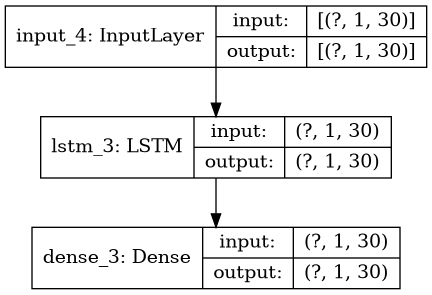

In [91]:
model = initializeNet()
keras.utils.plot_model(model, 'LSTMTest_images/net.png', show_shapes=True)

Input shape: (5, 1, 30)
Output shape: (5, 1, 30)


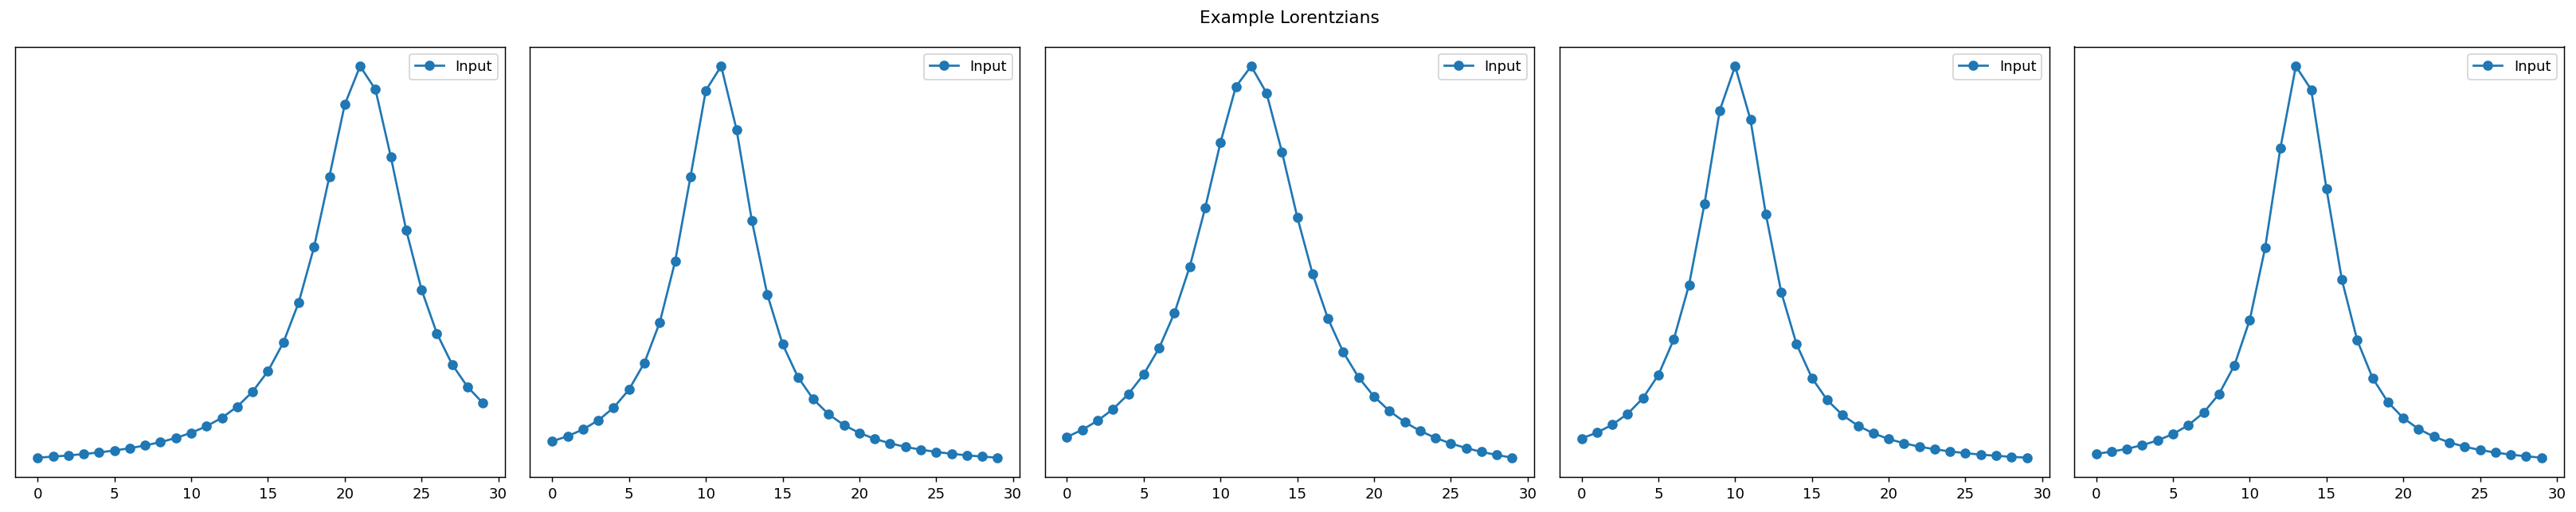

In [92]:
inputs, outputs = generateBatchOneHot(5)

print(f'Input shape: {np.shape(inputs)}')
print(f'Output shape: {np.shape(outputs)}')

#print(fake_loss(badOutput, outputs))
#print(localizationError(badOutput, outputs))

fig, ax = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):
    ax[i].plot(inputs[i,0,:], 'o-', label='Input')
    #ax[i].plot(outputs[i,:,0], 'o', label='Output')
    #ax[i].plot(badOutput[i,:,0], 'o', label='Random output')
    ax[i].set_yticks([])
    ax[i].legend()
    #ax[i].set_xticks([])
    
fig.suptitle('Example Lorentzians')
fig.tight_layout()
plt.savefig('LSTMTest_images/lorentzian_samples.png')
plt.show()

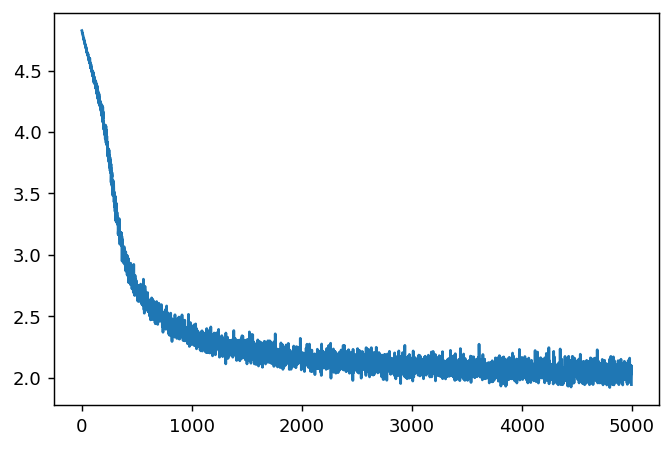

In [93]:
batchsize = 100
trainingSteps = 5000

error = np.zeros(trainingSteps)

for i in range(trainingSteps):
    inputs, outputs = generateBatchOneHot(batchsize)
    
    error[i] = model.train_on_batch(inputs, outputs)[0]
    clear_output(wait=True)
    plt.plot(error)
    plt.show()

tf.Tensor(
[[0.38568298]
 [0.26840187]
 [0.64243256]
 [0.70926478]
 [0.57458289]], shape=(5, 1), dtype=float64)
tf.Tensor(
[[0.38568298]
 [0.26840187]
 [0.64243256]
 [0.70926478]
 [0.57458289]], shape=(5, 1), dtype=float64)


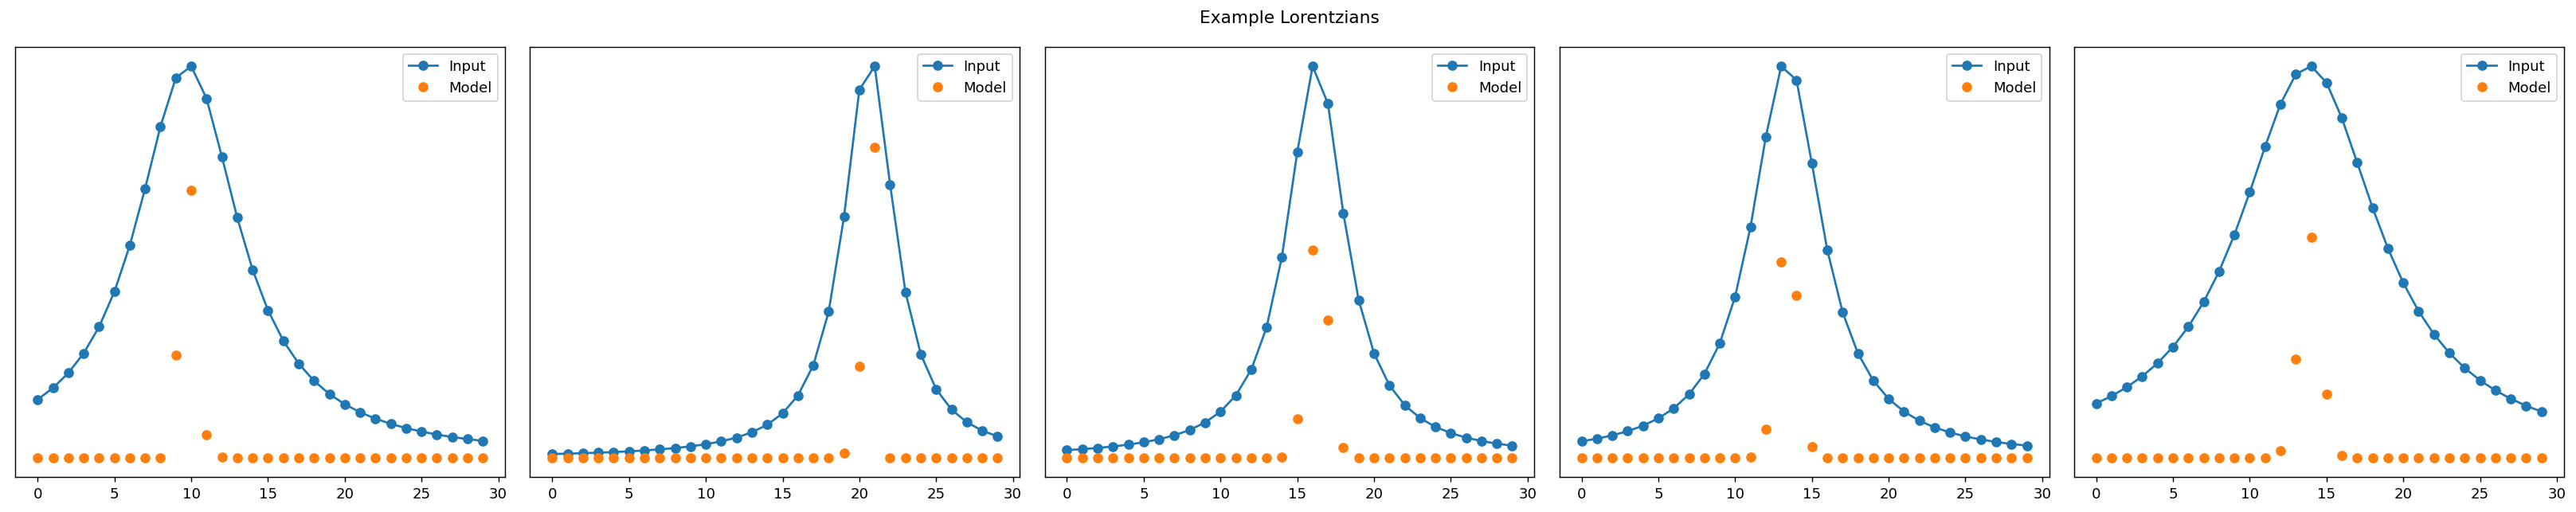

In [95]:
inputs, outputs = generateBatchOneHot(5)
predictions = model.predict_on_batch(inputs)
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

inputsT = tf.constant(inputs, shape=(5, 1, 30))
outputsT = tf.constant(outputs, shape=(5, 1, 30))
predictionsT = tf.constant(predictions, dtype='float64')

print(keras_CCE(outputsT, predictionsT))
#print(keras.losses.CategoricalCrossentropy(predictions, outputs))
print(kb.categorical_crossentropy(outputsT, predictionsT))

#plottableOutputs = np.zeros_like(inputs)
#for i in range(len(inputs)):
#    plottableOutputs[i][0][outputs[i]] = 1
    
for i in range(5):
    ax[i].plot(inputs[i,0,:], 'o-', label='Input')
    ax[i].plot(predictions[i,0,:], 'o', label='Model')
    #ax[i].plot(plottableOutputs[i,0,:], 'o', label='Output')
    ax[i].set_yticks([])
    ax[i].legend()
    #ax[i].set_xticks([])
    
fig.suptitle('Example Lorentzians')
fig.tight_layout()
plt.savefig('results.png')
plt.show()